Install efficientnet for pytorch

In [2]:
!pip install efficientnet-pytorch

In [55]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
!pip install matplotlib pandas pyarrow

Import required libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

Extract data

In [26]:
#copy data zip from drive
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/uni/Honours/ISIC_2019.zip ./ISIC_2019.zip

#unzip dataset
!unzip -x -q ISIC_2019.zip

#remove zip file
!rm ISIC_2019.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace ISIC_2019_Resized/ISIC_0000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Sort data into folders based on class

In [5]:
# function to sort the images into class folders based on given csv file
def copy_images_to_folders(csv_path, image_folder, output_folder):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        image_name = row['image'] + '.jpg'  # Assuming images have '.jpg' extension
        image_path = os.path.join(image_folder, image_name)

        # Iterate through class columns and copy images to the corresponding folders
        for class_name in df.columns[1:]:
            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)  # Create folder if it doesn't exist

            if row[class_name] == 1:  # Check if the image belongs to the class
                shutil.copy(image_path, class_folder)

csv_path = 'ISIC_2019_Training_GroundTruth.csv'
image_folder = 'ISIC_2019_Resized'
output_folder = 'ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)


Select random subset of data from every class for training and validation

In [6]:
# declare variables for model creation
input_folder = 'ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data_subset'  # The desired output folder for "training" and "validation" folders
#data_dir = '/content/data_subset'
num_samples=500
validation_ratio=0.2
set_batch_size=32

#sample numbers by class copied here for reference
#MEL	NV	  BCC	  AK	BKL	  DF	VASC	SCC	UNK
#4522	12875	3323	867	2624	239	253	  628	0

'''
Melanoma (MEL)
Melanocytic nevus (NV)
Basal cell carcinoma (BCC)
Actinic keratosis (AK)
Benign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
Dermatofibroma (DF)
Vascular lesion (VASC)
Squamous cell carcinoma (SCC)
None of the others (UNK)
'''

'\nMelanoma (MEL)\nMelanocytic nevus (NV)\nBasal cell carcinoma (BCC)\nActinic keratosis (AK)\nBenign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]\nDermatofibroma (DF)\nVascular lesion (VASC)\nSquamous cell carcinoma (SCC)\nNone of the others (UNK)\n'

In [7]:
# Remove existing "training" and "validation" folders if they exist
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

In [8]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]

        # Randomly shuffle the list of images
        random.shuffle(images)

        #calculate size of class
        class_size = len(os.listdir(os.path.join(input_folder, class_name)))

        # Calculate the number of samples for training and validation
        num_training_samples = int(class_size * (1 - validation_ratio))
        #num_validation_samples = class_size - num_training_samples

        # Create the class subfolders within the "training" and "validation" folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)

        # Copy images to the "training" folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)

        # Copy images to the "validation" folder
        for image_name in images[num_training_samples:class_size]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)

In [9]:
#remove unknown folder as no samples
shutil.rmtree("data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data_subset/val/UNK", ignore_errors=True)

In [10]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [11]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#print checks to see if the values are the same - if yes then can remove the assignment here
print(f"file: ", class_names)
class_names = image_datasets['train'].classes
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'UNK', 'VASC']
file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
# get the sample size for each class
class_sizes = [len(os.listdir(os.path.join(training_folder, class_name))) for class_name in class_names]

# get the max sample size across classes
max_class_size = max(class_sizes)

# Calculate the desired repetitions for each class
# this is the number of times a sample needs to be repeated to match the max class size
desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

# Iterate through each class and oversample accordingly
for class_index, class_name in enumerate(class_names):
    #get the training folder for the current class
    class_folder_training = os.path.join(training_folder, class_name)
    class_indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == class_index]

    weights = [1.0 if label != class_index else desired_repetitions[class_index] for label in image_datasets['train'].targets]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    # Update the data loader for the "training" set with the weighted sampler
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=set_batch_size, sampler=sampler, num_workers=2)

oversample validation set for testing

In [29]:
# Duplicate validation dataset
image_datasets['val_oversampled'] = copy.deepcopy(image_datasets['val'])

# Create a dataloader for the oversampled validation dataset
val_oversampled_dataloader = torch.utils.data.DataLoader(image_datasets['val_oversampled'], batch_size=set_batch_size, shuffle=False, num_workers=2)

# Oversample the validation dataset
val_desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

for class_index, class_name in enumerate(class_names):
    val_class_folder = os.path.join(output_folder, 'val', class_name)
    val_class_indices = [i for i, label in enumerate(image_datasets['val_oversampled'].targets) if label == class_index]

    val_weights = [1.0 if label != class_index else val_desired_repetitions[class_index] for label in image_datasets['val_oversampled'].targets]
    val_sampler = WeightedRandomSampler(val_weights, len(val_weights), replacement=True)

    # Update the sampler for the existing dataloader
    val_oversampled_dataloader = torch.utils.data.DataLoader(image_datasets['val_oversampled'], batch_size=set_batch_size, sampler=val_sampler, num_workers=2)

# Calculate the size of the oversampled validation dataset and add it to dataset_sizes
dataset_sizes['val_oversampled'] = len(image_datasets['val_oversampled'])

# Assign the final oversampled dataloader to the dictionary
dataloaders['val_oversampled'] = val_oversampled_dataloader

show sample images

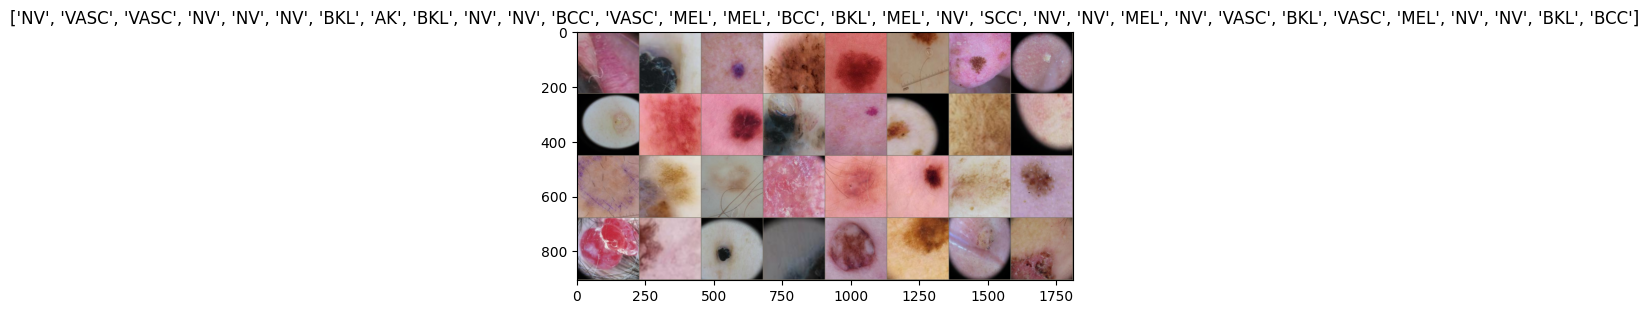

In [30]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

model training function

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f'Epoch {epoch}/{num_epochs - 1} - {current_time}')
            print('-' * 10)

            for phase in ['train', 'val', 'val_oversampled']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                data_loader = dataloaders[phase]

                for inputs, labels in data_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
                elif phase == 'val':
                    print(f'Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}')
                elif phase == 'val_oversampled':
                    print(f'Over Val Loss: {epoch_loss:.4f}, Over Val Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model

temporary fix for efficientnet weights issue

In [32]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [ ]:
model_ft = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

MC dropout test

In [ ]:
class CustomEfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.5):
        super(CustomEfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes, pretrained=True)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the model with dropout
model_ft = CustomEfficientNetB0(num_classes=len(class_names), dropout_prob=0.5)

In [33]:
class CustomEfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.5):
        super(CustomEfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)

        # Iterate over all modules in the model
        for module in self.model.children():
            if isinstance(module, nn.Linear):
                # If the module is a fully connected layer, add dropout
                module.add_module('dropout', nn.Dropout(dropout_prob))

    def forward(self, x):
        x = self.model(x)
        return x

# Initialize the model with dropout
model_ft = CustomEfficientNetB0(num_classes=len(class_names), dropout_prob=0.5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\euand/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100.0%


Loaded pretrained weights for efficientnet-b0


In [34]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

train model

In [35]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24 - 2024-01-31 05:42:54
----------


KeyboardInterrupt: 

visualise trained model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                title = f'Predicted: {predicted_class}\nActual: {actual_class}'
                ax.set_title(title)

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft, num_images=10)

method for calculating uncertainties

In [ ]:
def calculate_uncertainties(model, dataloader, uncertainty_func, class_names, device, use_mc_dropout=False, num_samples=10):
    guesses_are_correct = []
    uncertainties = []

    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            if use_mc_dropout:
                model.train()
                mc_outputs = torch.zeros((num_samples,) + model(inputs).shape).to(device)

                for k in range(num_samples):
                    mc_outputs[k] = model(inputs)

                model.eval()
                outputs = mc_outputs.mean(dim=0)
            else:
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(len(inputs)):
                try:
                    predicted_class = class_names[preds[j]]
                    actual_class = class_names[labels[j]]
                    guesses_are_correct.append(actual_class == predicted_class)

                    if use_mc_dropout:
                        uncertainty = uncertainty_func(mc_outputs[:, j])
                    else:
                        uncertainty = uncertainty_func(outputs[j])

                    uncertainties.append(uncertainty)
                except IndexError as e:
                    continue

    model.train(mode=was_training)

    return guesses_are_correct, uncertainties

In [ ]:
def calculate_uncertainties(model, dataloader, uncertainty_func, class_names, device, use_mc_dropout=False, num_samples=10):
    guesses_are_correct = []
    uncertainties = []

    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            if use_mc_dropout:
                model.train()
                mc_outputs = torch.zeros((num_samples,) + model(inputs).shape).to(device)

                for k in range(num_samples):
                    mc_outputs[k] = model(inputs)

                model.eval()
                outputs = mc_outputs.mean(dim=0)
            else:
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(len(class_names)):
                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                guesses_are_correct.append(actual_class == predicted_class)

                if use_mc_dropout:
                    uncertainty = uncertainty_func(mc_outputs[:, j])
                else:
                    uncertainty = uncertainty_func(outputs[j])

                uncertainties.append(uncertainty)

    model.train(mode=was_training)

    return guesses_are_correct, uncertainties

method for calculating risks by coverage

In [ ]:
def calculate_risks(guesses_are_correct, uncertainties):
    risks = []

    while uncertainties:
        risk = 1 - (sum(guesses_are_correct) / len(guesses_are_correct))
        risks.append(risk)

        max_uncertainty_index = uncertainties.index(max(uncertainties))
        uncertainties.pop(max_uncertainty_index)
        guesses_are_correct.pop(max_uncertainty_index)

    risks.reverse()

    return risks

calculate risks against coverage for softmax response

In [ ]:
# For softmax uncertainty
softmax_guesses_are_correct, softmax_uncertainties = calculate_uncertainties(
    model_ft,
    dataloaders['val'],
    lambda x: 1 - torch.max(F.softmax(x, dim=0)).item(),
    class_names,
    device,
    use_mc_dropout=False  # Set use_mc_dropout to False
)

softmax_risks = calculate_risks(softmax_guesses_are_correct, softmax_uncertainties)

Sample 0:
   Predicted: NV, Actual: NV
   Uncertainty: 0.04208403825759888
Sample 1:
   Predicted: VASC, Actual: BKL
   Uncertainty: 0.2002856731414795
Sample 2:
   Predicted: NV, Actual: NV
   Uncertainty: 0.15455442667007446
Sample 3:
   Predicted: BCC, Actual: BCC
   Uncertainty: 0.5070399343967438
Sample 4:
   Predicted: NV, Actual: NV
   Uncertainty: 0.20470768213272095
Sample 5:
   Predicted: BKL, Actual: BKL
   Uncertainty: 0.63739213347435
Sample 6:
   Predicted: NV, Actual: NV
   Uncertainty: 0.10968989133834839
Sample 7:
   Predicted: NV, Actual: NV
   Uncertainty: 0.12834513187408447
Sample 32:
   Predicted: MEL, Actual: MEL
   Uncertainty: 0.020906269550323486
Sample 33:
   Predicted: NV, Actual: NV
   Uncertainty: 0.29959118366241455
Sample 34:
   Predicted: NV, Actual: NV
   Uncertainty: 0.23343485593795776
Sample 35:
   Predicted: NV, Actual: BKL
   Uncertainty: 0.3401118516921997
Sample 36:
   Predicted: NV, Actual: NV
   Uncertainty: 0.13443243503570557
Sample 37:
   P

MC dropout

In [ ]:
# For Monte Carlo Dropout with softmax uncertainty
mc_dropout_guesses_are_correct, mc_dropout_uncertainties = calculate_uncertainties(
    model_ft,
    dataloaders['val'],
    lambda x: 1 - torch.max(F.softmax(x, dim=0)).item(),
    class_names,
    device,
    use_mc_dropout=True,
    num_samples=10  # Adjust the number of Monte Carlo samples as needed
)

mc_dropout_risks = calculate_risks(mc_dropout_guesses_are_correct, mc_dropout_uncertainties)

Sample 0:
   Predicted: BKL, Actual: SCC
   Uncertainty: 0.8328862488269806
Sample 1:
   Predicted: MEL, Actual: BCC
   Uncertainty: 0.8135150074958801
Sample 2:
   Predicted: NV, Actual: NV
   Uncertainty: 0.7856507450342178
Sample 3:
   Predicted: NV, Actual: NV
   Uncertainty: 0.8225113600492477
Sample 4:
   Predicted: VASC, Actual: VASC
   Uncertainty: 0.7489317059516907
Sample 5:
   Predicted: VASC, Actual: SCC
   Uncertainty: 0.8149168640375137
Sample 6:
   Predicted: MEL, Actual: MEL
   Uncertainty: 0.6888523697853088
Sample 7:
   Predicted: NV, Actual: MEL
   Uncertainty: 0.785290464758873
Sample 32:
   Predicted: VASC, Actual: BCC
   Uncertainty: 0.8257929533720016
Sample 33:
   Predicted: NV, Actual: NV
   Uncertainty: 0.8409708738327026
Sample 34:
   Predicted: VASC, Actual: AK
   Uncertainty: 0.8279556334018707
Sample 35:
   Predicted: NV, Actual: NV
   Uncertainty: 0.7549928724765778
Sample 36:
   Predicted: BKL, Actual: BKL
   Uncertainty: 0.7969970107078552
Sample 37:
  

calculate risks against coverage for random uncertainties

In [ ]:
# For random uncertainty
random_guesses_are_correct, random_uncertainties = calculate_uncertainties(
    model_ft,
    dataloaders['val'],
    lambda x: random.uniform(0, 1),
    class_names,
    device,
    use_mc_dropout=False  # Set use_mc_dropout to False
)

random_risks = calculate_risks(random_guesses_are_correct, random_uncertainties)

Sample 0:
   Predicted: NV, Actual: MEL
   Uncertainty: 0.5666008096607823
Sample 1:
   Predicted: NV, Actual: MEL
   Uncertainty: 0.34021242770488536
Sample 2:
   Predicted: VASC, Actual: VASC
   Uncertainty: 0.4964383729171953
Sample 3:
   Predicted: NV, Actual: NV
   Uncertainty: 0.8104200993246308
Sample 4:
   Predicted: NV, Actual: NV
   Uncertainty: 0.24923287533367267
Sample 5:
   Predicted: VASC, Actual: MEL
   Uncertainty: 0.14446031495614442
Sample 6:
   Predicted: BKL, Actual: MEL
   Uncertainty: 0.8695905904730793
Sample 7:
   Predicted: NV, Actual: NV
   Uncertainty: 0.2503831390118494
Sample 32:
   Predicted: NV, Actual: NV
   Uncertainty: 0.010359615453086501
Sample 33:
   Predicted: VASC, Actual: DF
   Uncertainty: 0.09730078542661202
Sample 34:
   Predicted: VASC, Actual: BCC
   Uncertainty: 0.6203713883595792
Sample 35:
   Predicted: VASC, Actual: BCC
   Uncertainty: 0.7862564771785872
Sample 36:
   Predicted: NV, Actual: NV
   Uncertainty: 0.49772631210695106
Sample 

plot the results

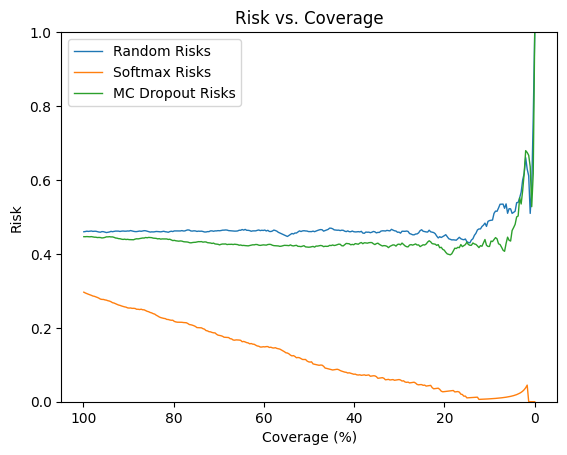

In [ ]:
# Interpolate the data for smoother curves
x_values = np.arange(len(random_risks))
total_steps = len(x_values)

# Convert x-values to percentage
x_smooth_percentage = (x_values / total_steps) * 100

# Create a smooth range for the x-axis
x_smooth_percentage_interp = np.linspace(x_smooth_percentage.min(), x_smooth_percentage.max(), 300)

# Interpolate the data based on the percentage values
random_risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, random_risks)
softmax_risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, softmax_risks)
mc_dropout_risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, mc_dropout_risks)

# Plotting the results with smooth curves
plt.plot(x_smooth_percentage_interp, random_risks_smooth, label='Random Risks', linewidth=1)
plt.plot(x_smooth_percentage_interp, softmax_risks_smooth, label='Softmax Risks', linewidth=1)
plt.plot(x_smooth_percentage_interp, mc_dropout_risks_smooth, label='MC Dropout Risks', linewidth=1)

# x-axis label with a percentage
plt.xlabel('Coverage (%)')
plt.ylabel('Risk')
plt.title('Risk vs. Coverage')

# Adjust the y-axis limits
plt.ylim(0, 1)

# Invert the x-axis
plt.gca().invert_xaxis()

# Show legend
plt.legend()

plt.show()
